## Review Rating Prediction

### Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
import matplotlib.pyplot as plt

%matplotlib inline
print('Libraries imported')

Using TensorFlow backend.


Libraries imported


## Data Import

In [2]:
df = pd.read_csv('full_merge.csv')
data = df.loc[:, ('Reviews', 'Rating')]
data.Reviews = data.Reviews.astype(str)
data.Rating = data.Rating.astype(float)
data

,Reviews,Rating
0,"""my son is halfway through his fourth week of ...",8.0
1,"""the actavis generic version of this medicatio...",1.0
2,"""my son was just diagnosed adhd today. he&#039...",7.0
3,"""the first few days on 1 mg in the morning, he...",4.0
4,"""ours 8 year old son as done so much better wi...",10.0
...,...,...
337348,i am having some of these side effects and wil...,2.0
337349,"made me tired,achy,and was told not to take st...",2.0
337350,it makes me feel like crap after i take it.\ni...,3.0
337351,when i strated taking the medication i was fin...,2.0


### Splitting among test/train

In [3]:
n = data.shape[0] #337354 
split_ratio = 0.8
sample_size = int(n*split_ratio)
rev_samp = data.sample(n = n, random_state = 42)

train = rev_samp[0:sample_size]
test = rev_samp[sample_size:]
train.shape, test.shape

((269882, 2), (67471, 2))

## Label Exploration

                                                  Reviews  Rating
116446  "this medication has helped tremendously. i we...     9.0
89204   "very helpful for this medicine for several us...     7.0
307676  i'm 17 and i've been on levora for four months...     7.0
164875  this is my first time using this name brand in...     7.0
236445  i had uncontrolled high blood pressure for yea...    10.0


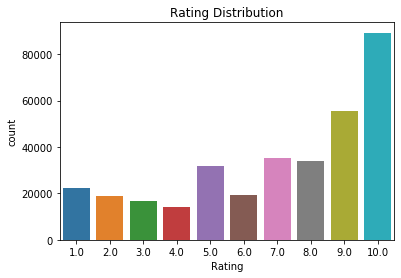

In [4]:
print(train.head())
sns.countplot(data['Rating']).set_title('Rating Distribution')
plt.show()

## One-hot Encoding

In [5]:

print('One-Hot Encoding')
train = pd.get_dummies(train, columns = ['Rating'])
print('On Train')
train.head()

One-Hot Encoding
On Train


,Reviews,Rating_1.0,Rating_2.0,Rating_3.0,Rating_4.0,Rating_5.0,Rating_6.0,Rating_7.0,Rating_8.0,Rating_9.0,Rating_10.0
116446,"""this medication has helped tremendously. i we...",0,0,0,0,0,0,0,0,1,0
89204,"""very helpful for this medicine for several us...",0,0,0,0,0,0,1,0,0,0
307676,i'm 17 and i've been on levora for four months...,0,0,0,0,0,0,1,0,0,0
164875,this is my first time using this name brand in...,0,0,0,0,0,0,1,0,0,0
236445,i had uncontrolled high blood pressure for yea...,0,0,0,0,0,0,0,0,0,1


In [6]:
test = pd.get_dummies(test, columns = ['Rating'])
print('Train and test shape')
train.shape, test.shape


Train and test shape


((269882, 11), (67471, 11))

### Setting train, test fractions

In [7]:
# set frac = 1 to use the entire sample
train_samp = train.sample(frac = 1, random_state = 42)
test_samp = test.sample(frac = 1, random_state = 42)
print(train_samp.shape, test_samp.shape)
print(train_samp.head())

(269882, 11) (67471, 11)
                                                  Reviews  Rating_1.0  \
127413                                             "wow!"           0   
173144  have not grown a tolerance as fast compared to...           0   
163138  after the very first dose, my 15 yr old daught...           0   
120216  "within 1 hr of taking - starting shaking unco...           1   
319226  never been on ad before have been on pristique...           0   

        Rating_2.0  Rating_3.0  Rating_4.0  Rating_5.0  Rating_6.0  \
127413           0           0           0           0           0   
173144           0           0           0           0           0   
163138           0           0           0           1           0   
120216           0           0           0           0           0   
319226           0           0           0           0           0   

        Rating_7.0  Rating_8.0  Rating_9.0  Rating_10.0  
127413           0           0           1            0  

## Long Short Term Memory - LSTM Model


In [8]:
# Defining parameters
# max number of unique words 
max_features = 20000
# max number of words from review to use
maxlen = 200


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

class_names = ['Rating_1.0','Rating_2.0','Rating_3.0','Rating_4.0','Rating_5.0',\
               'Rating_6.0','Rating_7.0','Rating_8.0','Rating_9.0','Rating_10.0']
# Splitting off my y variable
print('Y data')
y = train_samp[class_names].values
print(y.shape)
print(y)

# Train test split
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['Reviews'].values))
X_train = tokenizer.texts_to_sequences(train_samp['Reviews'].values)
X_test = tokenizer.texts_to_sequences(test_samp['Reviews'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

print('X test data')
print(x_test)
print(x_test.shape)

Y data
(269882, 10)
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
X test data
[[   0    0    0 ...   18 1271 1572]
 [   0    0    0 ...  282 1496  133]
 [   0    0    0 ...   44    9    4]
 ...
 [   0    0    0 ...  234  109  130]
 [   0    0    0 ...  107  382   56]
 [   0    0    0 ...   57   10 1681]]
(67471, 200)


### Saving tokenizer 

In [10]:
import pickle

# saving tokenizer 
with open('./ml_model/tokenizer/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)
print('tokenizer saved')

### Saving reviews for embedding

In [11]:
review_df = df.loc[:, ('Reviews')]
np.savetxt(r'./ml_model/reviews/review.txt', review_df.values, fmt='%s')
print('text file created')

text file created


## Training LSTM Model

In [12]:
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU

embed_size = 20

inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(10, activation = 'sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)


# patience is how many epochs to wait to see if val_loss will improve again
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True,\
                             filepath = './ml_model/weights/lstm_gru_weights.hdf5')

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Model Training

In [13]:
print('Model Training Initiated')
epoch = 10
model.fit(x_train, y, batch_size = 512, epochs = epoch, validation_split = .2, callbacks=[earlystop, checkpoint])
print('Model Training Completed')

Model Training Initiated

Train on 215905 samples, validate on 53977 samples
Epoch 1/15
215905/215905 [==============================] - 899s 4ms/step - loss: 0.3172 - accuracy: 0.8977 - val_loss: 0.3035 - val_accuracy: 0.9000
Epoch 2/15
215905/215905 [==============================] - 1012s 5ms/step - loss: 0.2869 - accuracy: 0.9012 - val_loss: 0.2722 - val_accuracy: 0.9030
Epoch 3/15
215905/215905 [==============================] - 1175s 5ms/step - loss: 0.2711 - accuracy: 0.9036 - val_loss: 0.2658 - val_accuracy: 0.9049
Epoch 4/15
215905/215905 [==============================] - 1043s 5ms/step - loss: 0.2647 - accuracy: 0.9050 - val_loss: 0.2617 - val_accuracy: 0.9064
Epoch 5/15
215905/215905 [==============================] - 878s 4ms/step - loss: 0.2601 - accuracy: 0.9062 - val_loss: 0.2587 - val_accuracy: 0.9071
Epoch 6/15
215905/215905 [==============================] - 933s 4ms/step - loss: 0.2563 - accuracy: 0.9073 - val_loss: 0.2573 - val_accuracy: 0.9074
Epoch 7/15
215905/21

### Model Evaluation

In [14]:
y_test = model.predict([x_test], batch_size=1024, verbose = 1)
y_test

67471/67471 [==============================] - 75s 1ms/step


array([[2.1836370e-02, 6.1109722e-02, 9.0967178e-02, ..., 1.3090125e-01,
        8.2291573e-02, 3.4377366e-02],
       [1.2873816e-01, 2.5853574e-01, 1.3665751e-01, ..., 5.2336454e-03,
        4.3954253e-03, 6.2325895e-03],
       [5.7628751e-04, 1.4342070e-03, 1.6046464e-03, ..., 9.5746666e-02,
        3.6057347e-01, 4.9624893e-01],
       ...,
       [1.7083442e-01, 3.0567479e-01, 1.2189457e-01, ..., 6.3704550e-03,
        4.5021772e-03, 8.9263916e-03],
       [3.5002142e-02, 5.4802805e-02, 2.3658156e-02, ..., 2.3000658e-02,
        6.7750394e-02, 6.2087578e-01],
       [6.0574114e-03, 1.6927749e-02, 2.2586703e-02, ..., 1.7381477e-01,
        2.3631261e-01, 2.9184023e-01]], dtype=float32)

### Model Accuracy

In [15]:
from sklearn import metrics
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.41      0.70      0.52      4435
           1       0.26      0.16      0.20      3741
           2       0.00      0.00      0.00      3353
           3       0.00      0.00      0.00      2780
           4       0.23      0.31      0.26      6279
           5       0.21      0.00      0.00      3753
           6       0.24      0.37      0.29      7056
           7       0.22      0.13      0.16      6774
           8       0.34      0.27      0.30     11299
           9       0.55      0.75      0.64     18001

    accuracy                           0.38     67471
   macro avg       0.24      0.27      0.24     67471
weighted avg       0.32      0.38      0.34     67471



/Users/Shubham/AnacondaNavigator/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Saving model

In [16]:
model.save('./ml_model/model/review_rating_pred.h5')
print('Model Saved')

Model Saved


### Model Testing

In [4]:
from keras.models import load_model

lstm = load_model('./ml_model/model/review_rating_pred.h5')
tokenizer_test = pd.read_pickle('./ml_model/tokenizer/tokenizer.pkl')
print('Model Loaded')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model Loaded


#### Sample review prediction

In [5]:
# Sample Reviews (Bad, moderate(less bad), Good)
# 'Intunive did not work for my son; he was bouncing off the walls while he was taking it, and having major issues in class! It seems to work the opposite on him!'
# 'Increased dose from 1mg to 2 mg now urinating in bed every night, bad effect'
# 'Good experience, it has worked well for my son for about 2 months now.. For some that say they can no longer afford because of insurance. Some places sell generic for under 10$ a month'

s = 1
review_list = []
rating = [1, 3, 8]
review1 = ['Intunive did not work for my son; he was bouncing off the walls while he was taking it, and having major issues in class! It seems to work the opposite on him!']
review2 = ['Increased dose from 1mg to 2 mg now urinating in bed every night, bad effect, worse, major pain']
review3 = ['Good experience, it has worked well for my son for about 2 months now.. For some that say they can no longer afford because of insurance. Some places sell generic for under 10$ a month']

review_list.append(review1)
print(review2)
review_list.append(review2)
review_list.append(review3)


for sample in review_list:
    X_sample = tokenizer_test.texts_to_sequences(sample)
    print('Review ', s)
    print('Original Rating', rating[s-1])
    x_sample = pad_sequences(X_sample, maxlen = 200)
    y_sample = lstm.predict([x_sample], batch_size = 512, verbose = 1)

    y_max = np.argmax(y_sample, axis = 1)
    print('Predicted Rating',y_max + 1)
    s += 1
    print('')

['Increased dose from 1mg to 2 mg now urinating in bed every night, bad effect, worse, major pain']
Review  1
Original Rating 1
1/1 [==============================] - 0s 474ms/step
Predicted Rating [1]

Review  2
Original Rating 3
1/1 [==============================] - 0s 66ms/step
Predicted Rating [5]

Review  3
Original Rating 8
1/1 [==============================] - 0s 65ms/step
Predicted Rating [10]



### Predicting for entire sample

In [6]:
print('Read csv')
df = pd.read_csv('full_merge_emotion_sentiment.csv')
data = df.loc[:, ('Reviews', 'Rating')]
data.Reviews = data.Reviews.astype(str)

print('Tokenizing')
X_sample = tokenizer_test.texts_to_sequences(data['Reviews'].values)
x_sample = pad_sequences(X_sample, maxlen = 200)
print('Sample Prediction')
y_sample = lstm.predict([x_sample], batch_size=512, verbose = 1)

print('')
df['Predicted_rating'] = np.argmax(y_sample, axis=1)

Read csv
Tokenizing
Sample Prediction
337337/337337 [==============================] - 392s 1ms/step



In [7]:
print(df)
df.to_csv('full_merge_model_predictions.csv', index=False)
print('new dataframe saved as csv')
# %match		15%			66%			81%			89%

# new_rating	Exact	nearest 1	nearest 2	nearest 3

              Drug     Condition  \
0       guanfacine          adhd   
1       guanfacine          adhd   
2       guanfacine          adhd   
3       guanfacine          adhd   
4       guanfacine          adhd   
...            ...           ...   
337332   isoniazid  tuberculosis   
337333   isoniazid  tuberculosis   
337334   isoniazid  tuberculosis   
337335   isoniazid  tuberculosis   
337336     rifadin  tuberculosis   

                                                  Reviews  Rating    Website  \
0       "my son is halfway through his fourth week of ...       8  drugs.com   
1       "the actavis generic version of this medicatio...       1  drugs.com   
2       "my son was just diagnosed adhd today. he's 5 ...       7  drugs.com   
3       "the first few days on 1 mg in the morning, he...       4  drugs.com   
4       "ours 8 year old son as done so much better wi...      10  drugs.com   
...                                                   ...     ...        ...   
337332 